# Stack overflow 2017 survey analysis

In [4]:
import pandas as pd
import plotly.express as px
import pycountry

pd.options.display.max_columns = None
rawDf = pd.read_csv('developer_survey_2017/survey_results_public.csv')
countryAlpha = rawDf.Country.apply(lambda x: pycountry.countries.get(name=x).alpha_3 if pycountry.countries.get(name=x) else None)
df = rawDf.assign(CountryAlpha = countryAlpha)

## Audience

### Country origin

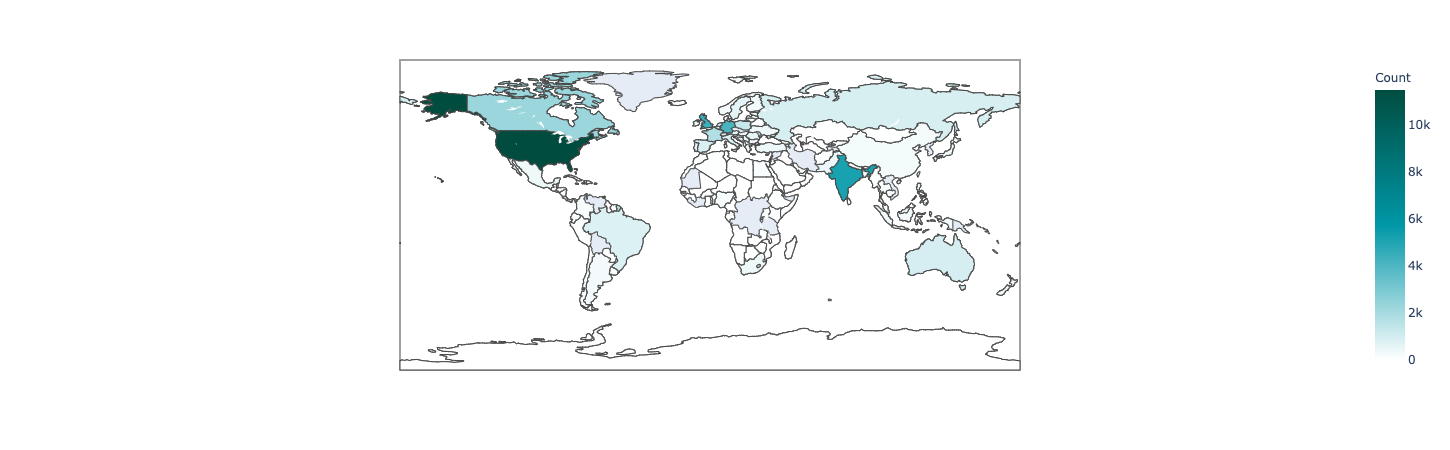

In [9]:
count_by_country_df = df.CountryAlpha.value_counts().to_frame(name="Count").reset_index().rename(columns={'index': 'CountryCode'})
count_by_country_df
fig = px.choropleth(count_by_country_df, locations = "CountryCode",
                    color="Count", # lifeExp is a column of gapminder
                    hover_name="CountryCode", # column to add to hover information
                    color_continuous_scale=["white", "#0097a7", "#004d40"])
fig.show()